In [1]:
from Medfl.LearningManager.utils import global_params

import sys
sys.path.append(global_params['base_url'])

import os
os.environ['PYTHONPATH'] = global_params['base_url']

In [2]:
import mysql.connector
import pandas as pd
from sqlalchemy import create_engine,text
import subprocess


# Torch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


## MedFL Imports 
## Network Manager Imports 
from Medfl.NetManager.node import Node
from Medfl.NetManager.network import Network
from Medfl.NetManager.dataset import DataSet
from Medfl.NetManager.flsetup import FLsetup

# flower imports 
import flwr as fl

## Learning Manager imports 
from Medfl.LearningManager.dynamicModal import DynamicModel
from Medfl.LearningManager.model import Model
from Medfl.LearningManager.strategy import Strategy
from Medfl.LearningManager.server import *
from Medfl.LearningManager.flpipeline import *
from Medfl.LearningManager.plot import AccuracyLossPlotter



# Utils
from Medfl.LearningManager.utils import *


2024-03-27 15:03:13.629047: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
class BinaryClassifier(nn.Module):
    def __init__(self, input_size, num_layers, layer_size):
        super(BinaryClassifier, self).__init__()

        # Input layer
        self.layers = [nn.Linear(input_size, layer_size)]
        
        # Hidden layers
        for _ in range(num_layers - 1):
            self.layers.append(nn.Linear(layer_size, layer_size))
        
        # Output layer
        self.layers.append(nn.Linear(layer_size, 1))
        
        # ModuleList to handle dynamic number of layers
        self.layers = nn.ModuleList(self.layers)

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        x = self.layers[-1](x)
        return x

In [4]:
centralized_score = 0.7774

In [5]:
# Best HyperParams using optuna optimisation 
best_hyperparams = {'batch_size': 16, 'num_layers': 6, 'hidden_size': 46,
                    'optimizer': 'RMSprop', 'learning_rate': 0.0019940796634093597, 'num_epochs': 1}

In [6]:
#  Best threshold
best_th = 0.3

In [7]:
# The number of server rounds
n_rounds = [1]

In [8]:
benchmarks_config = {
    # * 1 . Differential Privacy
    # *******************************************
    "diff_privacy": [
        # {
        #     # DP config
        #     "dp_activate": False,

        #     # The rest of the config
        #     "n_clients": 10,
        #     "train_test": True,
        #     "train_portion": 0.5,
        #     "aggreg_algo": "FedAvg",
        #     "Tl": True,
        # },
        # {
        #     # DP config
        #     "dp_activate": True,
        #     "DELTA": 1e-5,
        #     "EPSILON": 5.0,

        #     # The rest of the config
        #     "n_clients": 10,
        #     "train_test": True,
        #     "train_portion": 0.5,
        #     "aggreg_algo": "FedAvg",
        #     "Tl": True,
        # },
        # {
        #     # DP config
        #     "dp_activate": True,
        #     "DELTA": 1e-5,
        #     "EPSILON": 10.0,

        #     # The rest of the config
        #     "n_clients": 10,
        #     "train_test": True,
        #     "train_portion": 0.5,
        #     "aggreg_algo": "FedAvg",
        #     "Tl": True,
        # },
        # {
        #     # DP config
        #     "dp_activate": True,
        #     "DELTA": 1e-5,
        #     "EPSILON": 0.5,

        #     # The rest of the config
        #     "n_clients": 10,
        #     "train_test": True,
        #     "train_portion": 0.5,
        #     "aggreg_algo": "FedAvg",
        #     "Tl": True,
        # },
        # {
        #     # DP config
        #     "dp_activate": True,
        #     "DELTA": 0,
        #     "EPSILON": 0.5,

        #     # The rest of the config
        #     "n_clients": 10,
        #     "train_test": True,
        #     "train_portion": 0.5,
        #     "aggreg_algo": "FedAvg",
        #     "Tl": True,
        # },
        #       {
        #     # DP config
        #     "dp_activate": True,
        #     "DELTA": 0,
        #     "EPSILON": 5.0,

        #     # The rest of the config
        #     "n_clients": 10,
        #     "train_test": True,
        #     "train_portion": 0.5,
        #     "aggreg_algo": "FedAvg",
        #     "Tl": True,
        # }
    ],
    # * 2 . Nodes Config
    # *******************************************
    "nodes_config": [
        {
            # nodes config
            "train_test": True,
            "train_portion": 0.5,

            # The rest of the config
            "n_clients": 10,
            "dp_activate": False,
            "aggreg_algo": "FedAvg",
            "Tl": True,
        },
        {
            # nodes config
            "train_test": True,
            "train_portion": 0.7,

            # The rest of the config
            "n_clients": 10,
            "dp_activate": False,
            "aggreg_algo": "FedAvg",
            "Tl": True,
        },
        {
            # nodes config
            "train_test": False,
            "train_portion": 0.5,

            # The rest of the config
            "n_clients": 10,
            "dp_activate": False,
            "aggreg_algo": "FedAvg",
            "Tl": True,
        },
        {
            # nodes config
            "train_test": False,
            "train_portion": 0.7,

            # The rest of the config
            "n_clients": 10,
            "dp_activate": False,
            "aggreg_algo": "FedAvg",
            "Tl": True,
        },
    ],
    # * 3 . Aggregation Algorithm
    # *******************************************
    "Aggreg_algo": [
        {
            # Aggregation alrogithm
            "aggreg_algo": "FedAvg",

            # The rest of the config
            "train_test": True,
            "train_portion": 0.5,
            "n_clients": 10,
            "dp_activate": False,
            "Tl": True,
        },
        {
            # Aggregation alrogithm
            "aggreg_algo": "FedYogy",

            # The rest of the config
            "train_test": True,
            "train_portion": 0.5,
            "n_clients": 10,
            "dp_activate": False,
            "Tl": True,
        },
        {
            # Aggregation alrogithm
            "aggreg_algo": "FedAdaGrad",

            # The rest of the config
            "train_test": True,
            "train_portion": 0.5,
            "n_clients": 10,
            "dp_activate": False,
            "Tl": True,
        },
        {
            # Aggregation alro100githm
            "aggreg_algo": "FedAdam",

            # The rest of the config
            "train_test": True,
            "train_portion": 0.5,
            "n_clients": 10,
            "dp_activate": False,
            "Tl": True,
        },
    ],
    # * 4 . Aggregation Algorithm
    # *******************************************
    "n_clients": [
        {
            # Number of clients
            "n_clients": 5,

            # The rest of the config
            "train_test": True,
            "train_portion": 0.5,
            "aggreg_algo": "FedAvg",
            "dp_activate": False,
            "Tl": True,
        },
        {
            # Number of clients
            "n_clients": 10,

            # The rest of the config
            "train_test": True,
            "train_portion": 0.5,
            "aggreg_algo": "FedAvg",
            "dp_activate": False,
            "Tl": True,
        },
        {
            # Number of clients
            "n_clients": 30,

            # The rest of the config
            "train_test": True,
            "train_portion": 0.5,
            "aggreg_algo": "FedAvg",
            "dp_activate": False,
            "Tl": True,
        },

    ],
    # * 5 . Combine the configurations 
    # *******************************************
    "combined_config": []
}

In [17]:
benchmarks_config = {
    
    "TL": [
        {
            # Activate TL
            "Tl": True,

            # The rest of the config
            "train_test": True,
            "train_portion": 0.5,
            "aggreg_algo": "FedAvg",
            "dp_activate": False,
            "n_clients": 10,
            
        },
        #    {
        #     # Activate TL
        #     "Tl": False,

        #     # The rest of the config
        #     "train_test": True,
        #     "train_portion": 0.5,
        #     "aggreg_algo": "FedAvg",
        #     "dp_activate": False,
        #     "n_clients": 10,
            
        # },
       
    ],
}

In [18]:
# Benchmarks_result stors the result of each configuration in the benchmark 
benchmarks_results = []

In [19]:
# a fuction to test if the config is already tested
def is_config_tested(config , n_rounds):
    for result in benchmarks_results:
        if result['config'] == config and n_rounds == result['n_rounds'] : return True
    
    return False 

In [20]:
import pandas as pd
import os

def split_csv(input_file, output_directory, n):
    """
  
    """
    # Create output directory if it doesn't exist
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    else:
        # Clean the output directory by removing existing files
        for file in os.listdir(output_directory):
            file_path = os.path.join(output_directory, file)
            if os.path.isfile(file_path):
                os.remove(file_path)

    # Read the CSV file into a DataFrame
    df = pd.read_csv(input_file)

    # Calculate the number of rows in each part
    rows_per_part = len(df) // n

    # Split the DataFrame into n parts
    split_dataframes = [df.iloc[i*rows_per_part:(i+1)*rows_per_part] for i in range(n-1)]
    split_dataframes.append(df.iloc[(n-1)*rows_per_part:])

    # Save each part to a separate CSV file
    output_files = []
    for i, split_df in enumerate(split_dataframes):
        output_file = os.path.join(output_directory, f"output_{i+1}.csv")
        split_df.to_csv(output_file, index=False)
        output_files.append(output_file)

    return output_files

# Example usage:
input_csv = '../data/masterDataSet/Mimic_ouael.csv'
output_dir = '../data/nodesData'

In [21]:
import yaml

def update_yaml_file(file_path, param_name, new_value):
    """
    Update a parameter in a YAML file.
    
    Args:
        file_path (str): Path to the YAML file.
        param_name (str): Name of the parameter to update.
        new_value: New value for the parameter.
    """
    # Load YAML file into a dictionary
    with open(file_path, 'r') as file:
        yaml_data = yaml.safe_load(file)
    
    # Update the parameter value
    if param_name in yaml_data:
        yaml_data[param_name] = new_value
    else:
        print(f"Parameter '{param_name}' not found in the YAML file.")
        return
    
    # Save the updated dictionary back to the YAML file
    with open(file_path, 'w') as file:
        yaml.dump(yaml_data, file)





In [22]:
import os

def count_files_in_directory(directory):
    """
    Count the number of files in a directory.
    
    Args:
        directory (str): Path to the directory.
    
    Returns:
        int: Number of files in the directory.
    """
    # Initialize count
    file_count = 0
    
    # Iterate over files in the directory
    for _, _, files in os.walk(directory):
        file_count += len(files)
    
    return file_count



In [23]:
device = torch.device(
            f"cuda" if torch.cuda.is_available() else "cpu"
        )

In [24]:

# Loop Over the benchmark configs
for key in benchmarks_config.keys():
    print("Executing the: " + key + " configurations")
    for config in benchmarks_config[key]:
        print("Executing th confuguration")
        print(config)
        for server_rounds in n_rounds:
            if(is_config_tested(config=config , n_rounds=server_rounds)):
                break
            # Create the MEDfl pipeline for each config
            
            # if the differential privac is activated change the epsilon and delta on the params file 
            if(config["dp_activate"]):
                update_yaml_file(global_params['base_url'] + "/Medfl/LearningManager/params.yaml", "EPSILON", config['EPSILON'])
                update_yaml_file(global_params['base_url'] + "/Medfl/LearningManager/params.yaml", "DELTA", config['DELTA'])
 
            # DB Creation
            subprocess.run(['python3', '../../scripts/create_db.py'])

            # Create a nest work "Net_1"
            Net_1 = Network(name="manual_network_2")
            Net_1.create_network()

            # Create a MasterDataSet from Net_1
            Net_1.create_master_dataset()

            # auto FLsetup creation
            autoFl = FLsetup(name="Flsetup_2",
                             description="The second fl setup", network=Net_1)
            autoFl.create()

            # Spilt master Dataset on n part (n number of clients )
            if(count_files_in_directory(output_dir) != config['n_clients']):
                split_files = split_csv(input_csv, output_dir, config['n_clients'])

            # Create Nodes
            if (config['train_test']):
                n_train = int(config['n_clients']*config['train_portion']) + 1

                #  Create the Train nodes
                for i in range(1, 1 + n_train):
                    hospital = Node(name="hospital_"+str(i), train=1)
                    Net_1.add_node(hospital)
                    hospital.upload_dataset(
                        "hospital_"+str(i)+'_dataset', global_params['base_url'] + '/notebooks/data/nodesData/output_'+str(i)+'.csv')

                #  Create the test nodes
                for i in range(1 + n_train, config['n_clients'] + 1):
                    hospital = Node(name="hospital_"+str(40+i), train=0)
                    Net_1.add_node(hospital)
                    hospital.upload_dataset("hospital_"+str(40+i)+'_dataset',
                                            global_params['base_url'] + '/notebooks/data/nodesData/output_'+str(i)+'.csv')

                #  Create a test+train nodes
                else:
                    pass

            # Create FLDataSet
            fl_dataset = autoFl.create_federated_dataset(
                output="deceased",
                fit_encode=[],
                to_drop=["deceased"]
            )

            if (config['Tl']):
                # Load the pretrained model
                model = Model.load_model(
                    "../../notebooks/.ipynb_checkpoints/trainedModels/grid_search_classifier.pth")
            else:
                # Create the model with the suggested hyperparameters
                model = BinaryClassifier(input_size=fl_dataset.size,
                                         num_layers=best_hyperparams['num_layers'],
                                         layer_size=best_hyperparams['hidden_size'],)
           

            # Pass the specific_model to the Model class
            if best_hyperparams['optimizer'] == 'Adam':
                optimizer = optim.Adam(
                    model.parameters(), lr=best_hyperparams['learning_rate'])
            elif best_hyperparams['optimizer'] == 'SGD':
                optimizer = optim.SGD(model.parameters(),
                                      lr=best_hyperparams['learning_rate'])
            elif best_hyperparams['optimizer'] == 'RMSprop':
                optimizer = optim.RMSprop(
                    model.parameters(), lr=best_hyperparams['learning_rate'])

            # Define loss function and optimizer

            pos_weight = torch.tensor([(1 - best_th) / best_th])
            criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

            # Creating a new Model instance using the specific model created by DynamicModel
            global_model = Model(model, optimizer, criterion)

            # Get the initial params of the model
            init_params = global_model.get_parameters()

            # Create the strategy
            aggreg_algo = Strategy(config['aggreg_algo'],
                                   fraction_fit=1.0,
                                   fraction_evaluate=1.0,
                                   min_fit_clients=2,
                                   min_evaluate_clients=2,
                                   min_available_clients=2,
                                   initial_parameters=global_model.get_parameters())
            aggreg_algo.create_strategy()

            # Create The server
            server = FlowerServer(global_model,
                                  strategy=aggreg_algo,
                                  num_rounds=server_rounds,
                                  num_clients=len(fl_dataset.trainloaders),
                                  fed_dataset=fl_dataset,
                                  diff_privacy=config['dp_activate'],
                                  # You can change the resources alocated for each client based on your machine
                                  client_resources={
                                      'num_cpus': 1.0, 'num_gpus': 1.0}
                                  )
            # Create the pipeline
            ppl_1 = FLpipeline(name="the second fl_pipeline",
                               description="this is our first FL pipeline",
                               server=server)
            
            # Run the Traning of the model
            history = ppl_1.server.run()

            # Test the model 
            report = ppl_1.auto_test()
            
            #  Print the results of the config 
            print('\n\n--------------------------------------------------- \n\n')
            print(config)
            print(server_rounds)
            print(server.auc)
            print(report)
            print('\n\n --------------------------------------------------- \n\n')

            # Save the results in a txt file 
            with open('benchmarks_results.txt', 'a') as file:
                # Write the results in the txt file
                file.write('\n\n---------------------------------------------------\n\n')
                file.write(str(config) + '\n')
                file.write(str(server_rounds) + '\n')
                file.write(str(server.auc) + '\n')
                file.write('\n\n---------------------------------------------------\n\n')

            
            # store the results 
            benchmarks_results.append({
                'n_rounds' : server_rounds,
                'config' : config , 
                'results' : server.auc,
                'test_results' : report
            })


Executing the: TL configurations
Executing th confuguration
{'Tl': True, 'train_test': True, 'train_portion': 0.5, 'aggreg_algo': 'FedAvg', 'dp_activate': False, 'n_clients': 10}
/home/local/USHERBROOKE/saho6810/MEDfl/code/MEDfl/notebooks/data/masterDataSet/Mimic_ouael.csv


INFO flwr 2024-03-27 15:10:42,801 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
03/27/2024 15:10:42:INFO:Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2024-03-27 15:10:46,745	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-03-27 15:10:49,098 | app.py:213 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 24.0, 'accelerator_type:G': 1.0, 'GPU': 1.0, 'object_store_memory': 78643200.0, 'node:10.44.86.57': 1.0, 'memory': 33952078234.0}
03/27/2024 15:10:49:INFO:Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 24.0, 'accelerator_type:G': 1.0, 'GPU': 1.0, 'object_store_memory': 78643200.0, 'node:10.44.86.57': 1.0, 'memory': 33952078234.0}
INFO flwr 2024-03-27 15:10:49,099 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
03/27/2024 15:10:49:INFO:Optim

(DefaultActor pid=1439548) 
(DefaultActor pid=1439548)  -------------------------------- 
(DefaultActor pid=1439548)   this is the config of the client
(DefaultActor pid=1439548) [Client 5] fit, config: {}
(DefaultActor pid=1439548) 
(DefaultActor pid=1439548)  -------------------------------- 
(DefaultActor pid=1439548)   
(DefaultActor pid=1439548) 	Train Epoch: 0 	Loss: 0.858242 Acc@1: 55.937500
(DefaultActor pid=1439548) 	Train Epoch: 0 	Loss: 0.868745 Acc@1: 36.093750
(DefaultActor pid=1439548) 	Train Epoch: 1 	Loss: 0.858242 Acc@1: 55.937500
(DefaultActor pid=1439548) 	Train Epoch: 1 	Loss: 0.868745 Acc@1: 36.093750
(DefaultActor pid=1439548) 	Train Epoch: 2 	Loss: 0.858242 Acc@1: 55.937500
(DefaultActor pid=1439548) 	Train Epoch: 2 	Loss: 0.868745 Acc@1: 36.093750
(DefaultActor pid=1439548) 	Train Epoch: 3 	Loss: 0.858242 Acc@1: 55.937500
(DefaultActor pid=1439548) 	Train Epoch: 3 	Loss: 0.868745 Acc@1: 36.093750
(DefaultActor pid=1439548) 	Train Epoch: 4 	Loss: 0.858242 Acc@1: 

DEBUG flwr 2024-03-27 15:11:16,489 | server.py:236 | fit_round 1 received 6 results and 0 failures
03/27/2024 15:11:16:DEBUG:fit_round 1 received 6 results and 0 failures
WARNING flwr 2024-03-27 15:11:16,494 | fedavg.py:250 | No fit_metrics_aggregation_fn provided
03/27/2024 15:11:16:WARNING:No fit_metrics_aggregation_fn provided
INFO flwr 2024-03-27 15:11:16,502 | server.py:125 | fit progress: (1, 0.036441312116735125, {'accuracy': 0.7421875}, 27.384881515987217)
03/27/2024 15:11:16:INFO:fit progress: (1, 0.036441312116735125, {'accuracy': 0.7421875}, 27.384881515987217)
DEBUG flwr 2024-03-27 15:11:16,503 | server.py:173 | evaluate_round 1: strategy sampled 6 clients (out of 6)
03/27/2024 15:11:16:DEBUG:evaluate_round 1: strategy sampled 6 clients (out of 6)
(DefaultActor pid=1439548) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much fast

(DefaultActor pid=1439548) 	Train Epoch: 111 	Loss: 0.905359 Acc@1: 15.000000
(DefaultActor pid=1439548) 	Train Epoch: 111 	Loss: 0.878021 Acc@1: 20.156250
(DefaultActor pid=1439548) 	Train Epoch: 112 	Loss: 0.905359 Acc@1: 15.000000
(DefaultActor pid=1439548) 	Train Epoch: 112 	Loss: 0.878021 Acc@1: 20.156250
(DefaultActor pid=1439548) 	Train Epoch: 113 	Loss: 0.905359 Acc@1: 15.000000
(DefaultActor pid=1439548) 	Train Epoch: 113 	Loss: 0.878021 Acc@1: 20.156250
(DefaultActor pid=1439548) 	Train Epoch: 114 	Loss: 0.905359 Acc@1: 15.000000
(DefaultActor pid=1439548) 	Train Epoch: 114 	Loss: 0.878021 Acc@1: 20.156250
(DefaultActor pid=1439548) 	Train Epoch: 115 	Loss: 0.905359 Acc@1: 15.000000
(DefaultActor pid=1439548) 	Train Epoch: 115 	Loss: 0.878021 Acc@1: 20.156250
(DefaultActor pid=1439548) epsilon of client 2 : eps = 0
(DefaultActor pid=1439548) [Client 5] evaluate, config: {}
(DefaultActor pid=1439548) [Client 3] evaluate, config: {}


(DefaultActor pid=1439548) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
(DefaultActor pid=1439548)   warnings.warn(
(DefaultActor pid=1439548) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower.
(DefaultActor pid=1439548)   client = check_clientfn_returns_client(client_fn(cid))
(DefaultActor pid=1439548) /home/local/USHERBROOKE/s

(DefaultActor pid=1439548) [Client 4] evaluate, config: {}
(DefaultActor pid=1439548) [Client 2] evaluate, config: {}
(DefaultActor pid=1439548) [Client 1] evaluate, config: {}
(DefaultActor pid=1439548) [Client 0] evaluate, config: {}
[209   0  40   5]
[199   4  46   5]
[197   1  48   8]
[205   1  45   3]
[217   1  32   4]
[203   3  45   3]
[1061    3  186   19]
[1032    6  216   15]
[1050   14  185   20]
[1030    5  219   15]


--------------------------------------------------- 


{'Tl': True, 'train_test': True, 'train_portion': 0.5, 'aggreg_algo': 'FedAvg', 'dp_activate': False, 'n_clients': 10}
1
[0.48893229166666674, 0.48893229166666674]
[{'node_name': 'hospital_1', 'classification_report': "{'confusion matrix': {'TP': 5, 'FP': 0, 'FN': 40, 'TN': 209}, 'Accuracy': 0.843, 'Sensitivity/Recall': 0.111, 'Specificity': 1.0, 'PPV/Precision': 1.0, 'NPV': 0.839, 'F1-score': 0.2, 'False positive rate': 0.0, 'True positive rate': 0.111, 'auc': 0.5644869750132908}"}, {'node_name': 'hospita

In [ ]:
print(benchmarks_results)

[{'n_rounds': 50, 'config': {'Tl': True, 'train_test': True, 'train_portion': 0.5, 'aggreg_algo': 'FedAvg', 'dp_activate': False, 'n_clients': 10}, 'results': [0.5338997422330756, 0.5274894858228192, 0.5210792294125627, 0.5210792294125627, 0.5146689730023063, 0.5146689730023063, 0.5455331705331705, 0.5146689730023063, 0.5455331705331705, 0.5455331705331705, 0.5519434269434269, 0.5455331705331705, 0.5455331705331705, 0.5455331705331705, 0.5455331705331705, 0.5455331705331705, 0.5455331705331705, 0.5455331705331705, 0.5519434269434269, 0.5455331705331705, 0.5398188848188847, 0.5398188848188847, 0.5398188848188847, 0.5626760276760276, 0.5861803011803012, 0.5626760276760276, 0.5701546601546602, 0.5651451634784967, 0.5614516347849681, 0.56335639668973, 0.5614516347849681, 0.5838875322208655, 0.5662135395468728, 0.54335639668973, 0.5651451634784967, 0.5662135395468728, 0.5905541988875321, 0.5808540225206892, 0.5565133631800299, 0.575995115995116, 0.5674481074481075, 0.575995115995116, 0.5674

In [ ]:
import numpy as np

def get_results_by_categ(benchmarks_results , categ):
    results = []
    try:
        for res in benchmarks_results:
            if(res['config'] in benchmarks_config[categ]):
                results.append(res)
        
        centraized_results = np.full(n_rounds[0], centralized_score)
        results.append({
            "config" : {"MODE"  : "centralized"},
            "results" : centraized_results
        })
        return results
    except Exception as e :
        print(e)
        print(" Category not found in the benchmarking results")
        return []

    

In [ ]:
import matplotlib.pyplot as plt

def plot_benchmarks_results(benchmarks_results, categ):
    # Sample data
    data = get_results_by_categ(benchmarks_results=benchmarks_results, categ=categ)

    if data and len(data) != 0:
        # Group data by 'config' for separate graphs
        config_groups = {}
        plt.figure()

        for entry in data:
            config = entry['config']
            results = entry['results']
            plt.plot(range(1, len(results) + 1), results, marker='o', label=str(config))

        plt.xlabel('Number of Rounds')
        plt.ylabel('Results')
        plt.title('Results for ' + categ)

        # Place legend outside the plot area
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.grid(True)
        plt.show()
    return


# Number of clients Benchmarks

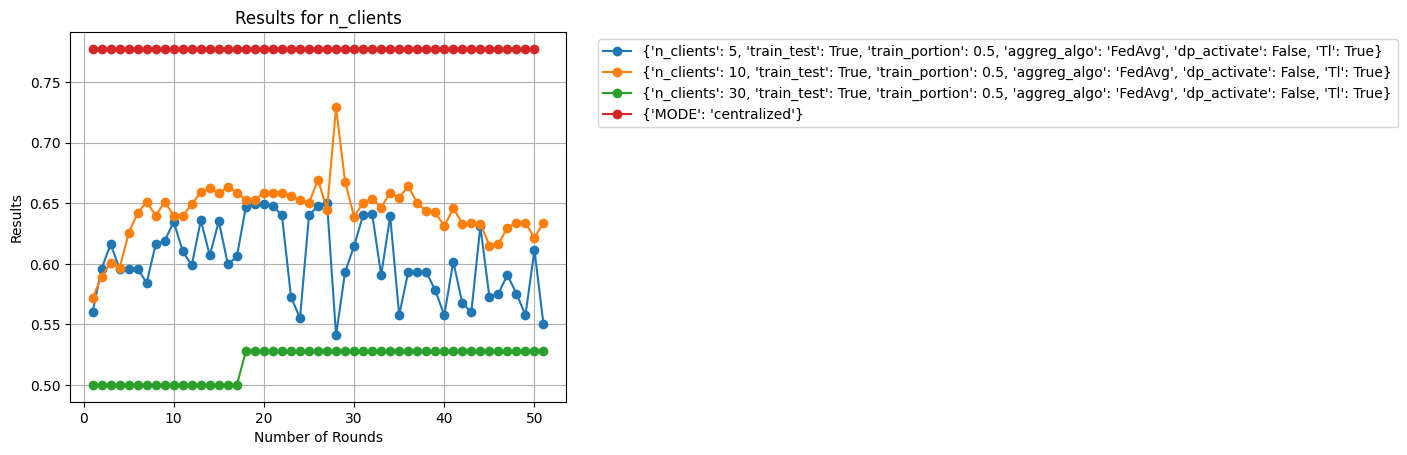

In [ ]:
plot_benchmarks_results(benchmarks_results=benchmarks_results , categ="n_clients" )

# Transfer Learning activation

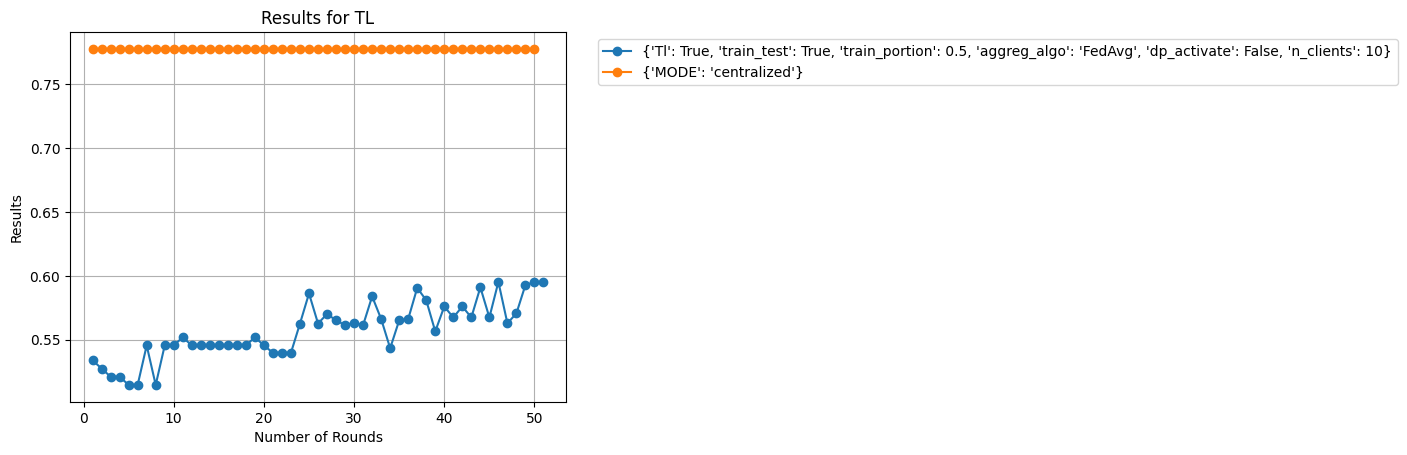

In [ ]:
plot_benchmarks_results(benchmarks_results=benchmarks_results , categ="TL" )